In [1]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import os
import re
import spacy
import pymorphy2

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPU Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPU Available:  1


In [6]:
os.path.join('ma_project', 'mult_lang_ds.csv')

'ma_project/mult_lang_ds.csv'

In [7]:
ukr_ds = pd.read_csv(os.path.join('ma_project', 'ukrainian_ds.csv'))
rus_ds = pd.read_csv(os.path.join('ma_project', 'russian_ds.csv'))


rus_ds.head(10)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"ОбъяснениеПочему были отменены правки, сделанн...",0.0,0.0,0.0,0.0,0.0,0.0
1,000103f0d9cfb60f,"Д'ау! Он соответствует этому цвету фона, с кот...",0.0,0.0,0.0,0.0,0.0,0.0
2,000113f07ec002fd,"Эй, чувак, я действительно не пытаюсь редактир...",0.0,0.0,0.0,0.0,0.0,0.0
3,0001b41b1c6bb37e,"""MoreЯ не могу сделать никаких реальных предло...",0.0,0.0,0.0,0.0,0.0,0.0
4,0001d958c54c6e35,"Вы, сэр, мой герой. Есть ли шанс, что вы помни...",0.0,0.0,0.0,0.0,0.0,0.0
5,00025465d4725e87,"«Поздравляю и от меня, хорошо используйте инст...",0.0,0.0,0.0,0.0,0.0,0.0
6,0002bcb3da6cb337,ПЕТУШОК ПЕРЕД ТОБОЙ ЗЛИТСЯ НА МОЮ РАБОТУ,1.0,1.0,1.0,0.0,1.0,0.0
7,00031b1e95af7921,Ваш вандализм в статье Мэтта Ширвингтона был в...,0.0,0.0,0.0,0.0,0.0,0.0
8,00037261F536c51d,"Извините, если слово «чепуха» было оскорбитель...",0.0,0.0,0.0,0.0,0.0,0.0
9,00040093b2687caa,выравнивание по этому вопросу и которые против...,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
ukr_ds.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,426417035bd5b20c,Пропоноване злиття з неформалізмом Ця стаття в...,0.0,0.0,0.0,0.0,0.0,0.0
1,4264fd1c363935d3,"""{| style=""""колір фону:#F5FFFA; заповнення:0;""...",0.0,0.0,0.0,0.0,0.0,0.0
2,4265fd7c2447bc08,"""Ви жили під скелею? Половина австралійської а...",0.0,0.0,0.0,0.0,0.0,0.0
3,4266b67c57e3cfbb,""" Японська назва міста Hi - Я переглянув свій ...",0.0,0.0,0.0,0.0,0.0,0.0
4,426a0fd1b3460373,– Ваше небажання обговорювати будь-які зміни с...,1.0,0.0,0.0,0.0,0.0,0.0
5,426b7152884d8ee3,– Реорганізація Зовсім втомилася від цього. Я ...,0.0,0.0,0.0,0.0,0.0,0.0
6,426d1e20956f1419,"""{| width=""""100%"""" style=""""фон:прозорий""""{| wi...",0.0,0.0,0.0,0.0,0.0,0.0
7,426d3e38cf37e9ec,Червона лінія: Я більше не можу спробувати ств...,0.0,0.0,0.0,0.0,0.0,0.0
8,426DD0A374FA5274,"Видалити, нечутливий. Якщо ви не думаєте, що ф...",0.0,0.0,0.0,0.0,0.0,0.0
9,426e1cca892876a5,Також що б ви запропонували бути першим?,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
def clean(text):
    text = text.fillna("fillna").str.lower()
    text = text.map(lambda x: re.sub('\\n',' ',str(x)))
    text = text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    text = text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    text = text.map(lambda x: re.sub("\(http://.*?\s\(http://.*\)",'',str(x)))
    return text

ukr_ds["comment_text"] = clean(ukr_ds["comment_text"])
rus_ds["comment_text"] = clean(rus_ds["comment_text"])

In [10]:
ukr_ds.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,426417035bd5b20c,пропоноване злиття з неформалізмом ця стаття в...,0.0,0.0,0.0,0.0,0.0,0.0
1,4264fd1c363935d3,"""{| style=""""колір фону:#f5fffa; заповнення:0;""...",0.0,0.0,0.0,0.0,0.0,0.0
2,4265fd7c2447bc08,"""ви жили під скелею? половина австралійської а...",0.0,0.0,0.0,0.0,0.0,0.0
3,4266b67c57e3cfbb,""" японська назва міста hi - я переглянув свій ...",0.0,0.0,0.0,0.0,0.0,0.0
4,426a0fd1b3460373,– ваше небажання обговорювати будь-які зміни с...,1.0,0.0,0.0,0.0,0.0,0.0
5,426b7152884d8ee3,– реорганізація зовсім втомилася від цього. я ...,0.0,0.0,0.0,0.0,0.0,0.0
6,426d1e20956f1419,"""{| width=""""100%"""" style=""""фон:прозорий""""{| wi...",0.0,0.0,0.0,0.0,0.0,0.0
7,426d3e38cf37e9ec,червона лінія: я більше не можу спробувати ств...,0.0,0.0,0.0,0.0,0.0,0.0
8,426DD0A374FA5274,"видалити, нечутливий. якщо ви не думаєте, що ф...",0.0,0.0,0.0,0.0,0.0,0.0
9,426e1cca892876a5,також що б ви запропонували бути першим?,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
rus_ds.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"объяснениепочему были отменены правки, сделанн...",0.0,0.0,0.0,0.0,0.0,0.0
1,000103f0d9cfb60f,"д'ау! он соответствует этому цвету фона, с кот...",0.0,0.0,0.0,0.0,0.0,0.0
2,000113f07ec002fd,"эй, чувак, я действительно не пытаюсь редактир...",0.0,0.0,0.0,0.0,0.0,0.0
3,0001b41b1c6bb37e,"""moreя не могу сделать никаких реальных предло...",0.0,0.0,0.0,0.0,0.0,0.0
4,0001d958c54c6e35,"вы, сэр, мой герой. есть ли шанс, что вы помни...",0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
nlp_ru = spacy.load('ru_core_news_sm', disable=['parser', 'ner'])
nlp_ukr = spacy.load('uk_core_news_sm', disable=['parser', 'ner'])

#Remove comments
ukr_ds['comment_text'] = ukr_ds['comment_text'].str.replace('[^\w\s]','')
ukr_ds['comment_text'].head()

/var/folders/cw/33f0r8bn1ybdsrn6qk814ptw0000gn/T/ipykernel_1264/1656484032.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  ukr_ds['comment_text'] = ukr_ds['comment_text'].str.replace('[^\w\s]','')


0    пропоноване злиття з неформалізмом ця стаття в...
1     styleколір фонуf5fffa заповнення0 cellpadding...
2    ви жили під скелею половина австралійської анг...
3     японська назва міста hi  я переглянув свій по...
4     ваше небажання обговорювати будьякі зміни сві...
Name: comment_text, dtype: object

In [13]:
rus_ds['comment_text'] = rus_ds['comment_text'].str.replace('[^\w\s]','')
rus_ds['comment_text'].head()

/var/folders/cw/33f0r8bn1ybdsrn6qk814ptw0000gn/T/ipykernel_1264/1857005239.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  rus_ds['comment_text'] = rus_ds['comment_text'].str.replace('[^\w\s]','')


0    объяснениепочему были отменены правки сделанны...
1    дау он соответствует этому цвету фона с которы...
2    эй чувак я действительно не пытаюсь редактиров...
3    moreя не могу сделать никаких реальных предлож...
4    вы сэр мой герой есть ли шанс что вы помните н...
Name: comment_text, dtype: object

In [14]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

ukr_ds['comment_text'] = ukr_ds['comment_text'].apply(lambda x: remove_emoji(x))
ukr_ds['comment_text'].tail(20)

22278    regression out friday 27 серпня 2015movie regr...
22279    допоможіть чи може хтось будь ласка скасувати ...
22280    я впевнений що хтось хто працює в страховій ко...
22281     помякшення наслідків зміни клімату та адаптац...
22282    не можу перемогти хахахахаха ви думали що може...
22283    cinevoter ви проголосували за співпрацю в кіно...
22284    наступні користувачі постійно вандалізують цю ...
22285    дивіться на всіх вебсторінках канадських зброй...
22286    йде круто для мене не потрібно зясовувати прич...
22287     classmessagebox standardtalk styletextalignce...
22288    посилання на великі рівнини перше речення стат...
22289    твій застряглий арсехол розважайся заради трах...
22290    категоріявікіпедисти які на невизначений термі...
22291     що робити з хронологією я майже закінчив пере...
22292                               ти дурний шматок лайна
22293    що сталося з юдою девліном я бачу що його біль...
22294     width100 styleфонпрозорий width100 styleфонов.

In [15]:
rus_ds['comment_text'] = rus_ds['comment_text'].apply(lambda x: remove_emoji(x))
rus_ds['comment_text'].tail(20)

21968    ну вот в чем проблема с либералом его значение...
21969    удаление обсуждения которое является неправдив...
21970    оспариваемое удаление эта страница не должна б...
21971    вопервых я бы очень хотел поблагодарить вас за...
21972    спасибо за предложения с наилучшими пожеланиям...
21973    в чем была проблема с шамита шеттимангалорцев ...
21974    дело sockpuppetry ваше имя было упомянуто в св...
21975             о это было не очень приятно сладкие щеки
21976    в последнее время я не просматривал википедию ...
21977    извините я не хотел помечать те с которыми у в...
21978            combichrist как насчет лирики combichrist
21979    я полностью согласен википедия не о списках ве...
21980    обама никогда не был вовлечен в какиелибо спор...
21981       редверс редверс преследовал и преследовал меня
21982    1 вы просто совершенно неправильно процитирова...
21983    это объясняется на странице обсуждения нервной...
21984    предложение о совместной работе над статьями в.

In [19]:
nltk.download('stopwords')
stop_ru = stopwords.words('russian')
stop_ukr = stopwords.words('ukrainian.txt')

ukr_ds['comment_text'] = ukr_ds['comment_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_ukr))
rus_ds['comment_text'] = rus_ds['comment_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_ru))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danyavdovenko/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
#Russian
TOKEN_RE = re.compile(r'[а-я]+')
lemmatizer = pymorphy2.MorphAnalyzer(lang='ru')

def tokenize_text(txt, min_lenght_token=2):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_lenght_token]

def remove_stopwords(tokens):
    return list(filter(lambda token: token not in stop_ru, tokens))

def lemmatizing(tokens):
    return [lemmatizer.parse(token)[0].normal_form for token in tokens]

def text_cleaning(txt):
    tokens = tokenize_text(txt)
    tokens  = lemmatizing(tokens)
    tokens = remove_stopwords(tokens)
    return ' '.join(tokens)

In [23]:
#Ukrainian
TOKEN_RE = re.compile(r'[а-щьюяєіїґҐґ]+')
lemmatizer = pymorphy2.MorphAnalyzer(lang='uk')

def tokenize_text(txt, min_lenght_token=2):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_lenght_token]

def remove_stopwords(tokens):
    return list(filter(lambda token: token not in stop_ukr, tokens))

def lemmatizing(tokens):
    return [lemmatizer.parse(token)[0].normal_form for token in tokens]

def text_cleaning(txt):
    tokens = tokenize_text(txt)
    tokens  = lemmatizing(tokens)
    tokens = remove_stopwords(tokens)
    return ' '.join(tokens)

In [21]:
from tqdm import tqdm
tqdm.pandas()

#Using russian stop words
rus_token = rus_ds.copy()
rus_token['comment_text'] = rus_token['comment_text'].progress_apply(text_cleaning)
rus_token.tail()

100%|████████████████████████████████████| 21988/21988 [00:57<00:00, 380.80it/s]


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
21983,3effe88a05807326,это объясняться страница обсуждение нервный ан...,1.0,0.0,0.0,0.0,0.0,0.0
21984,3f004f1df3b0eb0e,предложение совместный работа статья привет со...,0.0,0.0,0.0,0.0,0.0,0.0
21985,3f0065f71fac4bb8,это уля глостершир хотя одноимённый гастропаб ...,0.0,0.0,0.0,0.0,0.0,0.0
21986,3f006abae2ee3011,спасибо тёплый приём гомосексуальный гей фрукт...,1.0,0.0,0.0,0.0,0.0,0.0
21987,3f00739c10d916a9,ненависть являться адекватный реакция сцена из...,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#Using ukrainian stop words

ukr_token = ukr_ds.copy()
ukr_token['comment_text'] = ukr_token['comment_text'].progress_apply(text_cleaning)
ukr_token.tail()

100%|████████████████████████████████████| 22298/22298 [00:36<00:00, 617.50it/s]


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
22293,7e99f5b138965ab6,статися юда девлін бачити список зявитися джер...,0.0,0.0,0.0,0.0,0.0,0.0
22294,7e9a1572db8322b0,фонпрозорий фоновий колір ширина межа суцільни...,0.0,0.0,0.0,0.0,0.0,0.0
22295,7e9a2c55709fc300,брехня спільний користувач використовувати дет...,0.0,0.0,0.0,0.0,0.0,0.0
22296,7e9ab4d514fda065,додати фільмдорости вдома,0.0,0.0,0.0,0.0,0.0,0.0
22297,7e9aeab7c2763bae,черга фізика сила відчутний причина прискоренн...,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#Drop empty columns for ukrainian language

ukr_ds = ukr_token.copy()
ukr_ds = ukr_ds.dropna()

# check if there are remaining empty rows
if ukr_ds.isnull().any().any():
    print("There are remaining empty rows.")
else:
    print("There are no remaining empty rows.")

There are no remaining empty rows.


In [27]:
#Drop empty columns for russian language

rus_ds = rus_token.copy()
rus_ds = rus_ds.dropna()

# check if there are remaining empty rows
if rus_ds.isnull().any().any():
    print("There are remaining empty rows.")
else:
    print("There are no remaining empty rows.")

There are no remaining empty rows.


In [28]:
#Drop duplicates for ukr language 

print('Number of duplicates:', ukr_ds.duplicated().sum())
ukr_ds = ukr_ds.drop_duplicates()

Number of duplicates: 0


In [31]:
#Drop duplicates for rus language 

print('Number of duplicates:', rus_ds.duplicated().sum())
rus_ds = rus_ds.drop_duplicates()

Number of duplicates: 0


In [32]:
ukr_ds[ukr_ds.columns[2:]].iloc[56]

toxic            1.0
severe_toxic     0.0
obscene          1.0
threat           0.0
insult           1.0
identity_hate    0.0
Name: 56, dtype: float64

In [33]:
ukr_ds[ukr_ds['toxic'] == 1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
4,426a0fd1b3460373,небажання обговорювати будьякий змінити свідчи...,1.0,0.0,0.0,0.0,0.0,0.0
23,4276c5c78bb68b6d,хах хейсон знати надіслати електронний лист до...,1.0,0.0,0.0,0.0,0.0,0.0
48,428612964fe51b24,гей чорт важко отримати стать,1.0,0.0,1.0,0.0,0.0,0.0
56,428d29b82c56dfd5,можливо пропустити дискусія ласка заблокувати ...,1.0,0.0,1.0,0.0,1.0,0.0
60,428e828c7a7cec14,набирати півень рота,1.0,0.0,1.0,0.0,0.0,0.0


In [17]:
from tensorflow.keras.layers import TextVectorization

In [42]:
#Creation of preprocessed csv files
ukr_ds.to_csv(r'ma_project/preprocessed_datasets/ukr_ds_preprocessed.csv')
rus_ds.to_csv(r'ma_project/preprocessed_datasets/rus_ds_preprocessed.csv')

In [46]:
#Concatanation of datasets into one multilingual

multilingual_ds = pd.concat([ukr_ds, rus_ds])
print(multilingual_ds)

                     id  ... identity_hate
0      426417035bd5b20c  ...           0.0
1      4264fd1c363935d3  ...           0.0
2      4265fd7c2447bc08  ...           0.0
3      4266b67c57e3cfbb  ...           0.0
4      426a0fd1b3460373  ...           0.0
...                 ...  ...           ...
21983  3effe88a05807326  ...           0.0
21984  3f004f1df3b0eb0e  ...           0.0
21985  3f0065f71fac4bb8  ...           0.0
21986  3f006abae2ee3011  ...           0.0
21987  3f00739c10d916a9  ...           0.0

[43092 rows x 8 columns]


In [74]:
#Creation of preprocessed mult csv file
multilingual_ds.to_csv(r'ma_project/preprocessed_datasets/mult_ds_preprocessed.csv')

NameError: name 'multilingual_ds' is not defined

In [ ]:
###################################################################################################################

# Multilingual model (first train)

In [8]:
multilingual_ds = pd.read_csv(os.path.join('ma_project', 'preprocessed_datasets', 'mult_ds_preprocessed.csv'))

In [9]:
multilingual_ds = multilingual_ds.dropna()

In [10]:
multilingual_ds.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,426417035bd5b20c,пропонований злиття неформалізм стаття існуват...,0.0,0.0,0.0,0.0,0.0,0.0
1,1,4264fd1c363935d3,колір фон заповнення колір фон світлосірий вер...,0.0,0.0,0.0,0.0,0.0,0.0
2,2,4265fd7c2447bc08,жила скеля половина австралійський англійський...,0.0,0.0,0.0,0.0,0.0,0.0
3,3,4266b67c57e3cfbb,японський назва місто переглянути пост вікіпед...,0.0,0.0,0.0,0.0,0.0,0.0
4,4,426a0fd1b3460373,небажання обговорювати будьякий змінити свідчи...,1.0,0.0,0.0,0.0,0.0,0.0


In [12]:
multilingual_ds = multilingual_ds.dropna()

In [13]:
multilingual_ds.shape

(42881, 9)

In [26]:
#Splitting the dataset into comments and features

X = multilingual_ds['comment_text']
y = multilingual_ds[multilingual_ds.columns[3:]].values

In [27]:
X.tail()

43087    это объясняться страница обсуждение нервный ан...
43088    предложение совместный работа статья привет со...
43089    это уля глостершир хотя одноимённый гастропаб ...
43090    спасибо тёплый приём гомосексуальный гей фрукт...
43091    ненависть являться адекватный реакция сцена из...
Name: comment_text, dtype: object

In [28]:
y

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [15]:
MAX_FEATURES = 40_000 #number of words in the vocabluary

In [18]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES,
                               output_sequence_length = 1800,
                               output_mode = 'int')

Metal device set to: Apple M1


2023-03-06 22:04:42.238772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-06 22:04:42.239266: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
#A preprocessing layer which maps text features to integer sequences.
vectorizer.adapt(X.values)

2023-03-06 22:04:52.006231: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-06 22:04:52.051762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [20]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'это',
 'который',
 'статья',
 'сторінка',
 'страница',
 'стаття',
 'мочь',
 'ваш',
 'вікіпедія',
 'википедия',
 'должный',
 'являться',
 'свой',
 'стать',
 'правка',
 'ласка',
 'сделать',
 'человек',
 'зробити',
 'пожалуйста',
 'обсуждение',
 'иметь',
 'просто',
 'обговорення',
 'редактор',
 'спасибо',
 'знати',
 'время',
 'повинний',
 'джерело',
 'источник',
 'хотеть',
 'знать',
 'проблема',
 'право',
 'год',
 'посилання',
 'думати',
 'ссылка',
 'думать',
 'также',
 'хороший',
 'использовать',
 'говорить',
 'користувач',
 'робити',
 'список',
 'делать',
 'вопрос',
 'видалення',
 'редагування',
 'слово',
 'удалить',
 'удаление',
 'інформація',
 'информация',
 'сказать',
 'почему',
 'пользователь',
 'факт',
 'правило',
 'некоторый',
 'використовувати',
 'любой',
 'тема',
 'видалити',
 'причина',
 'дело',
 'зображення',
 'изображение',
 'поэтому',
 'добавить',
 'очень',
 'видеть',
 'день',
 'вважати',
 'можливо',
 'бачити',
 'несколько',
 'комментарий',
 'раздел',
 'розм

In [21]:
#Converting to a sequence of integers
vectorized_text = vectorizer(X.values)

In [22]:
vectorized_text

<tf.Tensor: shape=(42881, 1800), dtype=int64, numpy=
array([[ 3474,  1914, 32939, ...,     0,     0,     0],
       [  522,   734,  4440, ...,     0,     0,     0],
       [ 7267,  9327,  1531, ...,     0,     0,     0],
       ...,
       [    2, 29269, 27140, ...,     0,     0,     0],
       [   27,  8859,  3213, ...,     0,     0,     0],
       [ 1342,    13, 10179, ...,     0,     0,     0]])>

In [93]:
#MCSHBAP - map, cache, shuffle, batch, prefetch
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(40_000)
dataset = dataset.batch(10)
dataset = dataset.prefetch(8) #help prevents bottlenecks


In [91]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

2023-03-02 16:43:34.353705: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [98]:
int(len(dataset)*.7)

3017

In [99]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [100]:
len(train)

3017

In [101]:
len(val)

862

In [102]:
len(test)

431

In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
import scipy.stats
from sklearn.metrics import accuracy_score

confidence = 0.95  # Change to your desired confidence level
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
print(z_value)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

1.959963984540054


In [109]:
y[0]

array([0., 0., 0., 0., 0., 0.])

In [115]:
mult_model = Sequential()
#Create an embedding layer
mult_model.add(Embedding(MAX_FEATURES+1, 32))
#Create a LSTM layer
mult_model.add(Bidirectional(LSTM(32, activation = 'tanh')))
#Features extractors fully-connected layers
mult_model.add(Dense(128, activation ='relu'))
mult_model.add(Dense(256, activation = 'relu'))
mult_model.add(Dense(128, activation = 'relu'))
#Final layer
mult_model.add(Dense(6, activation = 'sigmoid'))



In [116]:
mult_model.compile(loss ='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])

In [117]:
mult_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          1280032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [119]:
history_mult_model = mult_model.fit(train, epochs=1, validation_data = val, callbacks = [callback])

Epoch 1/50


2023-03-02 17:42:51.665702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 17:42:51.956111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 17:42:51.974987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 17:43:03.375423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 17:43:03.389195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3017/3017 [==============================] - ETA: 0s - loss: 0.0906 - accuracy: 0.9670

2023-03-02 18:38:33.680997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 18:38:33.807392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-02 18:38:33.814910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3017/3017 [==============================] - 4017s 1s/step - loss: 0.0906 - accuracy: 0.9670 - val_loss: 0.0673 - val_accuracy: 0.9947
Epoch 2/50
3017/3017 [==============================] - 3945s 1s/step - loss: 0.0584 - accuracy: 0.9852 - val_loss: 0.0539 - val_accuracy: 0.9950
Epoch 3/50
3017/3017 [==============================] - 3932s 1s/step - loss: 0.0506 - accuracy: 0.9467 - val_loss: 0.0423 - val_accuracy: 0.9955
Epoch 4/50
3017/3017 [==============================] - 3943s 1s/step - loss: 0.0437 - accuracy: 0.9513 - val_loss: 0.0390 - val_accuracy: 0.9939
Epoch 5/50
3017/3017 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9770

KeyboardInterrupt: 

In [208]:
loss, acc = mult_model.evaluate(test, verbose =0)

In [209]:
print('Test accuracy %f' % (acc * 100))

Test accuracy 99.209672


In [130]:
print('loss %f' % loss)

loss 0.034709


In [199]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [204]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy

In [206]:
for batch in test.as_numpy_iterator():
    #Unpack the batch
    X_true, y_true = batch
    #Make prediction
    yhat = mult_model.predict(X_true)
    
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    #acc.update_state(y_true, yhat)
    

1/1 [==============================] - 1s 785ms/step


1/1 [==============================] - 10s 10s/step


In [213]:
f1_score = 2*(pre.result().numpy() * re.result().numpy())/(pre.result().numpy() + re.result().numpy())
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, F1-score:{f1_score}')

Precision: 0.8771084547042847, Recall:0.7353535890579224, F1-score:0.8000000295719927


In [196]:
batch_X, batch_y =  test.as_numpy_iterator().next()

In [192]:
input_text = vectorizer('тільки смерть!')

In [198]:
(mult_model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 1s 791ms/step


array([[0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [210]:
from sklearn.metrics import accuracy_score
ci_length = z_value * np.sqrt((acc * (1 - acc)) / y.shape[0])
ci_lower = acc - ci_length
ci_upper = acc + ci_length
print("Lower bound: ", ci_lower, "Upper bound: ", ci_upper)
print()
print("So, the above values represent the 95% confidence interval around the test set accuracy")

Lower bound:  0.9912606756923122 Upper bound:  0.9929327685597019

So, the above values represent the 95% confidence interval around the test set accuracy


## Model using one langauge (ukr)####

In [2]:
print(tf.config.list_physical_devices('CPU'))
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [57]:
#reading of preprocessed ukr csv file
ukr_ds = pd.read_csv(os.path.join('ma_project', 'preprocessed_datasets', 'ukr_ds_preprocessed.csv'))

In [58]:
rus_ds = pd.read_csv(os.path.join('ma_project', 'preprocessed_datasets', 'rus_ds_preprocessed.csv'))

### Ukrainian dataset ###

In [4]:
ukr_ds[ukr_ds["toxic"]==1].count()

Unnamed: 0       2136
id               2136
comment_text     2119
toxic            2136
severe_toxic     2136
obscene          2136
threat           2136
insult           2136
identity_hate    2136
dtype: int64

In [16]:
ukr_ds[ukr_ds["toxic"]==0].count()

Unnamed: 0       19610
id               19610
comment_text     19504
toxic            19610
severe_toxic     19610
obscene          19610
threat           19610
insult           19610
identity_hate    19610
dtype: int64

In [5]:
toxic_ukr = ukr_ds[ukr_ds["toxic"]==1].count()

In [6]:
ukr_ds[ukr_ds["severe_toxic"]==1].count()

Unnamed: 0       213
id               213
comment_text     208
toxic            213
severe_toxic     213
obscene          213
threat           213
insult           213
identity_hate    213
dtype: int64

In [17]:
ukr_ds[ukr_ds["severe_toxic"]==0].count()

Unnamed: 0       21533
id               21533
comment_text     21415
toxic            21533
severe_toxic     21533
obscene          21533
threat           21533
insult           21533
identity_hate    21533
dtype: int64

In [7]:
severe_toxic_ukr = ukr_ds[ukr_ds["severe_toxic"]==1].count()

In [8]:
ukr_ds[ukr_ds["obscene"]==1].count()

Unnamed: 0       1153
id               1153
comment_text     1142
toxic            1153
severe_toxic     1153
obscene          1153
threat           1153
insult           1153
identity_hate    1153
dtype: int64

In [18]:
ukr_ds[ukr_ds["obscene"]==0].count()

Unnamed: 0       20593
id               20593
comment_text     20481
toxic            20593
severe_toxic     20593
obscene          20593
threat           20593
insult           20593
identity_hate    20593
dtype: int64

In [9]:
obscene_ukr = ukr_ds[ukr_ds["obscene"]==1].count()

In [10]:
ukr_ds[ukr_ds["threat"]==1].count()

Unnamed: 0       74
id               74
comment_text     74
toxic            74
severe_toxic     74
obscene          74
threat           74
insult           74
identity_hate    74
dtype: int64

In [19]:
ukr_ds[ukr_ds["threat"]==0].count()

Unnamed: 0       21672
id               21672
comment_text     21549
toxic            21672
severe_toxic     21672
obscene          21672
threat           21672
insult           21672
identity_hate    21672
dtype: int64

In [11]:
threat_ukr = ukr_ds[ukr_ds["threat"]==1].count()

In [12]:
ukr_ds[ukr_ds["insult"]==1].count()

Unnamed: 0       1037
id               1037
comment_text     1028
toxic            1037
severe_toxic     1037
obscene          1037
threat           1037
insult           1037
identity_hate    1037
dtype: int64

In [13]:
insult_ukr = ukr_ds[ukr_ds["insult"]==1].count()

In [20]:
ukr_ds[ukr_ds["insult"]==0].count()

Unnamed: 0       20709
id               20709
comment_text     20595
toxic            20709
severe_toxic     20709
obscene          20709
threat           20709
insult           20709
identity_hate    20709
dtype: int64

In [27]:
ukr_ds[ukr_ds["identity_hate"]==1].count()


Unnamed: 0       196
id               196
comment_text     192
toxic            196
severe_toxic     196
obscene          196
threat           196
insult           196
identity_hate    196
dtype: int64

In [26]:
ukr_ds[ukr_ds["identity_hate"]==0].count()


Unnamed: 0       21550
id               21550
comment_text     21431
toxic            21550
severe_toxic     21550
obscene          21550
threat           21550
insult           21550
identity_hate    21550
dtype: int64

In [15]:
id_hate_urk = ukr_ds[ukr_ds["identity_hate"]==1].count()

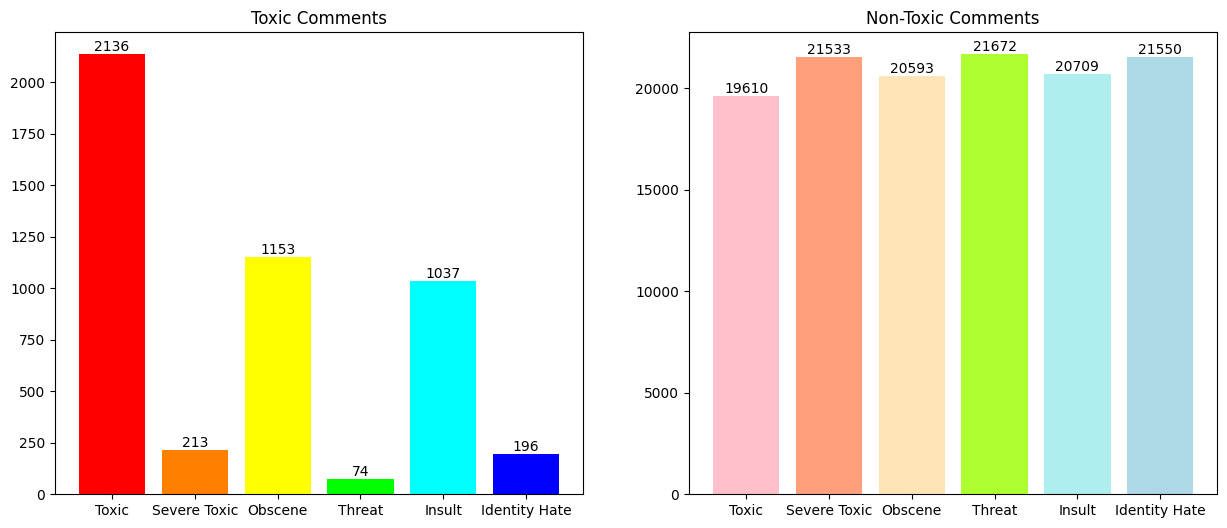

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Get the counts for each label
labels = ['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']
toxic_counts = [ukr_ds[ukr_ds['toxic'] == 1].count()[0], ukr_ds[ukr_ds['severe_toxic'] == 1].count()[0],
                ukr_ds[ukr_ds['obscene'] == 1].count()[0], ukr_ds[ukr_ds['threat'] == 1].count()[0],
                ukr_ds[ukr_ds['insult'] == 1].count()[0], ukr_ds[ukr_ds['identity_hate'] == 1].count()[0]]
non_toxic_counts = [ukr_ds[ukr_ds['toxic'] == 0].count()[0], ukr_ds[ukr_ds['severe_toxic'] == 0].count()[0],
                    ukr_ds[ukr_ds['obscene'] == 0].count()[0], ukr_ds[ukr_ds['threat'] == 0].count()[0],
                    ukr_ds[ukr_ds['insult'] == 0].count()[0], ukr_ds[ukr_ds['identity_hate'] == 0].count()[0]]

# Set the colors for the bars
toxic_colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#00FFFF', '#0000FF']
non_toxic_colors = ['#FFC0CB', '#FFA07A', '#FFE4B5', '#ADFF2F', '#AFEEEE', '#ADD8E6']

# Create two separate plots, one for the toxic comments and one for the non-toxic comments
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the bars for the toxic comments
ax1.bar(labels, toxic_counts, color=toxic_colors)
ax1.set_title('Toxic Comments')
for i, count in enumerate(toxic_counts):
    ax1.annotate(str(count), (labels[i], count), ha='center', va='bottom')

# Plot the bars for the non-toxic comments
ax2.bar(labels, non_toxic_counts, color=non_toxic_colors)
ax2.set_title('Non-Toxic Comments')
for i, count in enumerate(non_toxic_counts):
    ax2.annotate(str(count), (labels[i], count), ha='center', va='bottom')

plt.show()



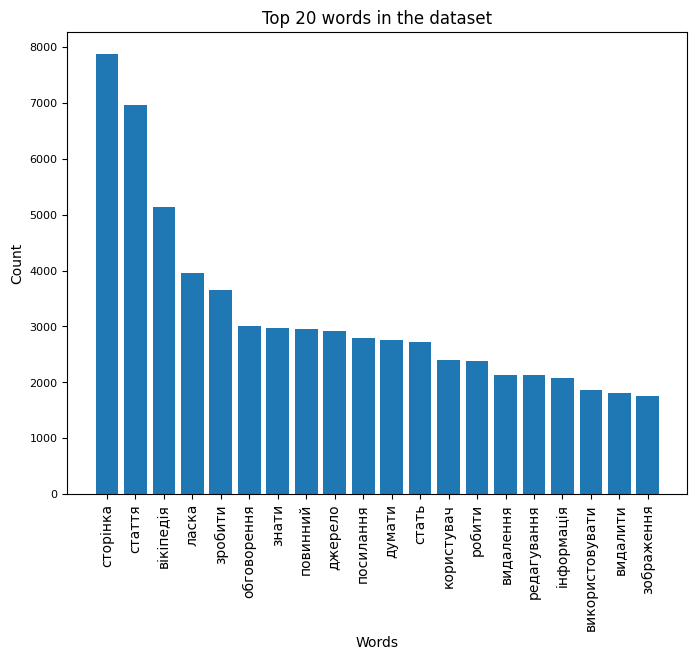

In [67]:
import matplotlib.pyplot as plt
from collections import Counter

# Tokenize the text
tokens = ukr_ds['comment_text'].str.lower().str.split()

# Count the tokens
word_counts = Counter([word for sentence in tokens for word in sentence])

# Select the most frequent tokens
num_top_words = 20
top_words = dict(word_counts.most_common(num_top_words))

# Plot the distribution of most frequent tokens
plt.figure(figsize=(8,6))
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=8)
plt.title('Top {} words in the dataset'.format(num_top_words), fontsize=12)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.show()




## Russian dataset ##

In [35]:
rus_ds[rus_ds["toxic"]==1].count()

Unnamed: 0       2039
id               2039
comment_text     2014
toxic            2039
severe_toxic     2039
obscene          2039
threat           2039
insult           2039
identity_hate    2039
dtype: int64

In [36]:
rus_ds[rus_ds["severe_toxic"]==1].count()

Unnamed: 0       223
id               223
comment_text     215
toxic            223
severe_toxic     223
obscene          223
threat           223
insult           223
identity_hate    223
dtype: int64

In [37]:
rus_ds[rus_ds["obscene"]==1].count()

Unnamed: 0       1103
id               1103
comment_text     1086
toxic            1103
severe_toxic     1103
obscene          1103
threat           1103
insult           1103
identity_hate    1103
dtype: int64

In [99]:
rus_ds[rus_ds["threat"]==1].count()

Unnamed: 0       69
id               69
comment_text     67
toxic            69
severe_toxic     69
obscene          69
threat           69
insult           69
identity_hate    69
dtype: int64

In [100]:
rus_ds[rus_ds["insult"]==1].count()

Unnamed: 0       1039
id               1039
comment_text     1027
toxic            1039
severe_toxic     1039
obscene          1039
threat           1039
insult           1039
identity_hate    1039
dtype: int64

In [38]:
rus_ds[rus_ds["identity_hate"]==1].count()

Unnamed: 0       182
id               182
comment_text     176
toxic            182
severe_toxic     182
obscene          182
threat           182
insult           182
identity_hate    182
dtype: int64

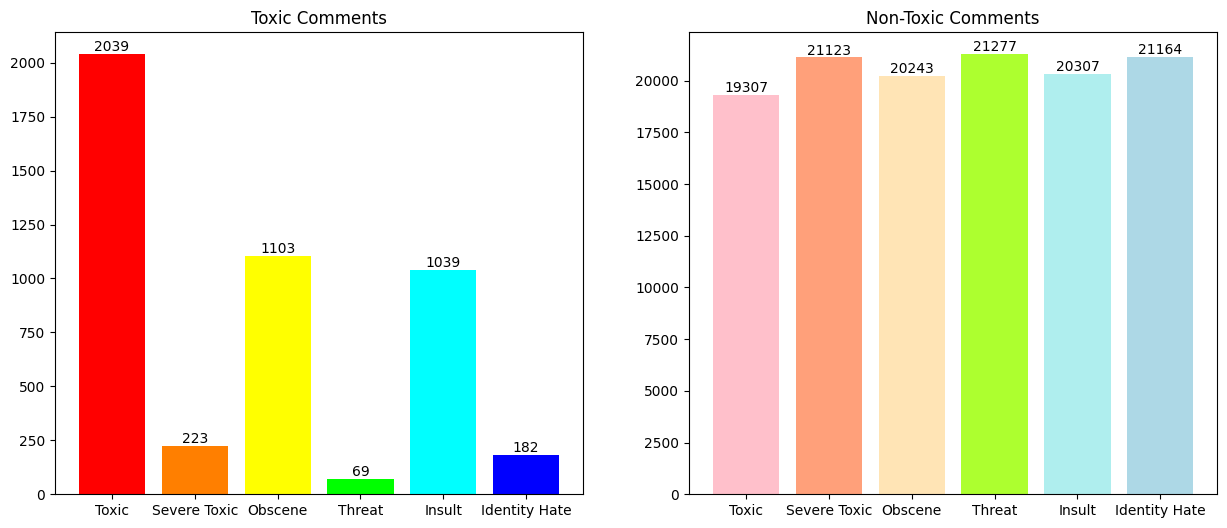

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Get the counts for each label
labels = ['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']
toxic_counts = [rus_ds[rus_ds['toxic'] == 1].count()[0], rus_ds[rus_ds['severe_toxic'] == 1].count()[0],
                rus_ds[rus_ds['obscene'] == 1].count()[0], rus_ds[rus_ds['threat'] == 1].count()[0],
                rus_ds[rus_ds['insult'] == 1].count()[0], rus_ds[rus_ds['identity_hate'] == 1].count()[0]]
non_toxic_counts = [rus_ds[rus_ds['toxic'] == 0].count()[0], rus_ds[rus_ds['severe_toxic'] == 0].count()[0],
                    rus_ds[rus_ds['obscene'] == 0].count()[0], rus_ds[rus_ds['threat'] == 0].count()[0],
                    rus_ds[rus_ds['insult'] == 0].count()[0], rus_ds[rus_ds['identity_hate'] == 0].count()[0]]

# Set the colors for the bars
toxic_colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#00FFFF', '#0000FF']
non_toxic_colors = ['#FFC0CB', '#FFA07A', '#FFE4B5', '#ADFF2F', '#AFEEEE', '#ADD8E6']

# Create two separate plots, one for the toxic comments and one for the non-toxic comments
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the bars for the toxic comments
ax1.bar(labels, toxic_counts, color=toxic_colors)
ax1.set_title('Toxic Comments')
for i, count in enumerate(toxic_counts):
    ax1.annotate(str(count), (labels[i], count), ha='center', va='bottom')

# Plot the bars for the non-toxic comments
ax2.bar(labels, non_toxic_counts, color=non_toxic_colors)
ax2.set_title('Non-Toxic Comments')
for i, count in enumerate(non_toxic_counts):
    ax2.annotate(str(count), (labels[i], count), ha='center', va='bottom')

plt.show()

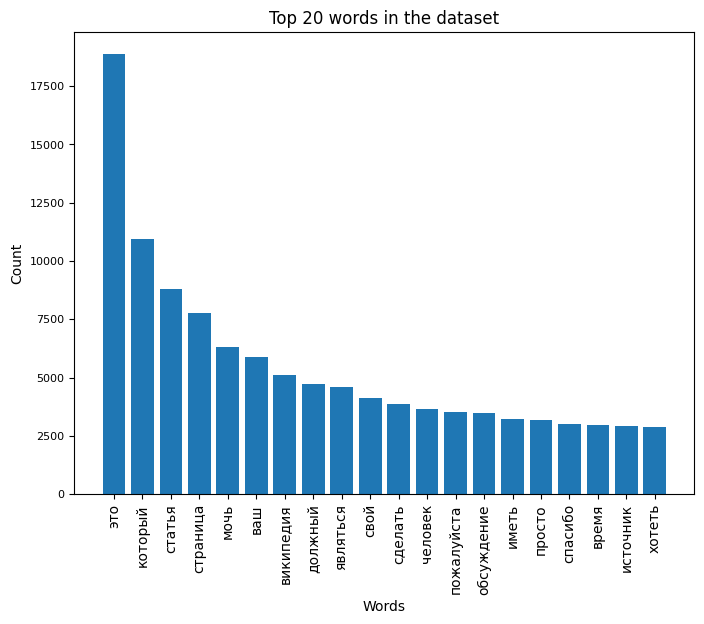

In [73]:
import matplotlib.pyplot as plt
from collections import Counter

# Tokenize the text
tokens = rus_ds['comment_text'].str.lower().str.split()

# Count the tokens
word_counts = Counter([word for sentence in tokens for word in sentence])

# Select the most frequent tokens
num_top_words = 20
top_words = dict(word_counts.most_common(num_top_words))

# Plot the distribution of most frequent tokens
plt.figure(figsize=(8,6))
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=8)
plt.title('Top {} words in the dataset'.format(num_top_words), fontsize=12)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.show()




In [72]:
rus_ds = rus_ds.dropna()


In [2]:
ukr_ds = pd.read_csv(os.path.join('ma_project', 'preprocessed_datasets', 'ukr_ds_preprocessed.csv'))

In [3]:
#Splitting the dataset into comments and features

X = ukr_ds['comment_text']
y = ukr_ds[ukr_ds.columns[3:]].values

In [4]:
X.shape

(21746,)

In [5]:
MAX_FEATURES = 21746 #number of words in the vocabluary

In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES,
                               output_sequence_length = 1800,
                               output_mode = 'int')

Metal device set to: Apple M1


2023-05-16 17:47:30.633782: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-16 17:47:30.634492: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
X = X.astype('str')

In [9]:
#A preprocessing layer which maps text features to integer sequences.
vectorizer.adapt(X.values)

2023-05-16 17:47:33.162799: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-16 17:47:33.214470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [10]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'сторінка',
 'стаття',
 'вікіпедія',
 'ласка',
 'зробити',
 'обговорення',
 'знати',
 'повинний',
 'джерело',
 'посилання',
 'думати',
 'стать',
 'користувач',
 'робити',
 'видалення',
 'редагування',
 'інформація',
 'використовувати',
 'видалити',
 'зображення',
 'правка',
 'право',
 'вважати',
 'можливо',
 'бачити',
 'редактор',
 'розмова',
 'розділ',
 'додати',
 'проблема',
 'будьякий',
 'коментар',
 'річ',
 'питання',
 'думка',
 'знайти',
 'насправді',
 'увага',
 'використання',
 'говорити',
 'випадок',
 'список',
 'новий',
 'історія',
 'отримати',
 'великий',
 'частина',
 'назва',
 'змінити',
 'редагувати',
 'внесок',
 'повідомлення',
 'намагатися',
 'слово',
 'привіт',
 'робот',
 'слід',
 'правило',
 'мова',
 'запис',
 'місце',
 'адміністратор',
 'вандалізм',
 'імя',
 'факт',
 'тема',
 'останній',
 'просити',
 'авторський',
 'політик',
 'заблокувати',
 'дати',
 'сподіватися',
 'стосуватися',
 'швидкий',
 'написати',
 'допомога',
 'особистий',
 'запитання',
 'допом

In [11]:
vectorized_text = vectorizer(X.values)

In [12]:
#MCSHBAP - map, cache, shuffle, batch, prefetch
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(21_000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(10) #help prevents bottlenecks

In [13]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

2023-05-16 17:47:39.182198: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.1))
test = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*.2))

In [15]:
len(train)

951

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
import scipy.stats
from sklearn.metrics import accuracy_score

confidence = 0.95  # Change to your desired confidence level
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
print(z_value)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

1.959963984540054


In [17]:
ukr_model = Sequential()
#Create an embedding layer
ukr_model.add(Embedding(MAX_FEATURES+1, 32))
#Create a LSTM layer
ukr_model.add(Bidirectional(LSTM(32, activation = 'tanh')))
#Features extractors fully-connected layers
ukr_model.add(Dense(128, activation ='relu'))
ukr_model.add(Dense(256, activation = 'relu'))
ukr_model.add(Dense(128, activation = 'relu'))
#Final layer
ukr_model.add(Dense(6, activation = 'sigmoid'))


In [18]:
ukr_model.compile(loss ='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])

In [19]:
ukr_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          695904    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [22]:
with tf.device('/CPU:0'):
    history = ukr_model.fit(train, epochs=5, validation_data = val)

Epoch 1/5
951/951 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9958

2023-05-16 17:54:38.770962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


951/951 [==============================] - 303s 318ms/step - loss: 0.0884 - accuracy: 0.9958 - val_loss: 0.0567 - val_accuracy: 0.9968
Epoch 2/5
951/951 [==============================] - 297s 312ms/step - loss: 0.0615 - accuracy: 0.9945 - val_loss: 0.0579 - val_accuracy: 0.9963
Epoch 3/5
951/951 [==============================] - 295s 310ms/step - loss: 0.0488 - accuracy: 0.9949 - val_loss: 0.0411 - val_accuracy: 0.9968
Epoch 4/5
951/951 [==============================] - 297s 313ms/step - loss: 0.0427 - accuracy: 0.9683 - val_loss: 0.0340 - val_accuracy: 0.9936
Epoch 5/5
951/951 [==============================] - 299s 315ms/step - loss: 0.0378 - accuracy: 0.9104 - val_loss: 0.0311 - val_accuracy: 0.9959


In [24]:
with tf.device('/CPU:0'):
    loss, acc = ukr_model.evaluate(test, verbose =0)

In [25]:
print('Test accuracy %f' % (acc * 100))

Test accuracy 99.515903


In [26]:
print('loss %f' % loss)

loss 0.030155


In [27]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy

with tf.device('/CPU:0'):
    for batch in test.as_numpy_iterator():
        #Unpack the batch
        X_true, y_true = batch
        #Make prediction
        yhat = ukr_model.predict(X_true)

        y_true = y_true.flatten()
        yhat = yhat.flatten()

        pre.update_state(y_true, yhat)
        re.update_state(y_true, yhat)
        #acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 51ms/step


2023-05-16 18:16:37.818753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 38ms/step


In [28]:
f1_score = 2*(pre.result().numpy() * re.result().numpy())/(pre.result().numpy() + re.result().numpy())
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, F1-score:{f1_score}')

Precision: 0.8868571519851685, Recall:0.7683168053627014, F1-score:0.823342124364206


<Figure size 800x500 with 0 Axes>

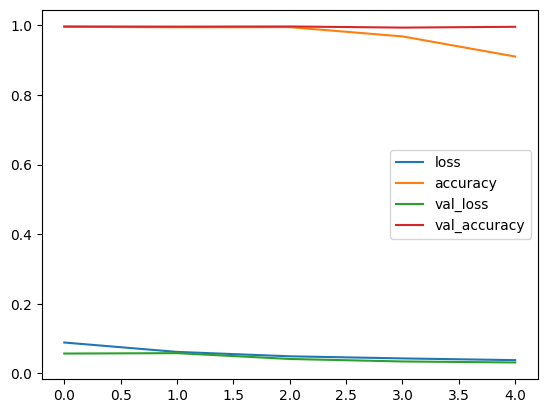

In [29]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

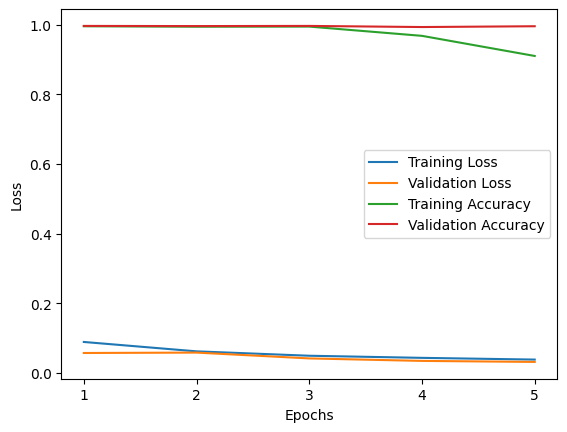

In [31]:
import matplotlib.pyplot as plt

# Assuming 'history' is the history object returned by model.fit()
epochs = range(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set the x-axis ticks to match the epoch values
plt.legend()
plt.show()

In [1]:
from sklearn.metrics import accuracy_score
ci_length = z_value * np.sqrt((acc * (1 - acc)) / y.shape[0])
ci_lower = acc - ci_length
ci_upper = acc + ci_length
print("Lower bound: ", ci_lower, "Upper bound: ", ci_upper)
print()
print("So, the above values represent the 95% confidence interval around the test set accuracy")

NameError: name 'z_value' is not defined

## Multilingual model, epochs = 6.

In [4]:
multilingual_ds = pd.read_csv(os.path.join('ma_project', 'preprocessed_datasets', 'mult_ds_preprocessed.csv'))

In [23]:
multilingual_dataset = pd.read_csv(os.path.join('ma_project', 'preprocessed_datasets', 'mult_ds_preprocessed.csv'))

In [5]:
#Splitting the dataset into comments and features

X = multilingual_ds['comment_text']
y = multilingual_ds[multilingual_ds.columns[3:]].values

In [6]:
MAX_FEATURES = 40_000 #number of words in the vocabluary

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES,
                               output_sequence_length = 1800,
                               output_mode = 'int')

Metal device set to: Apple M1


2023-03-25 19:23:37.958564: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-25 19:23:37.958962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
X = X.astype('str')

In [10]:
#A preprocessing layer which maps text features to integer sequences.
vectorizer.adapt(X.values)

2023-03-25 19:23:41.040408: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-25 19:23:41.096807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [11]:
#A preprocessing layer which maps text features to integer sequences.
vectorizer.adapt(X.values)

In [35]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'это',
 'который',
 'статья',
 'сторінка',
 'страница',
 'стаття',
 'мочь',
 'ваш',
 'вікіпедія',
 'википедия',
 'должный',
 'являться',
 'свой',
 'стать',
 'правка',
 'ласка',
 'сделать',
 'человек',
 'зробити',
 'пожалуйста',
 'обсуждение',
 'иметь',
 'просто',
 'обговорення',
 'редактор',
 'спасибо',
 'знати',
 'время',
 'повинний',
 'джерело',
 'источник',
 'хотеть',
 'знать',
 'проблема',
 'право',
 'год',
 'посилання',
 'думати',
 'ссылка',
 'думать',
 'также',
 'хороший',
 'использовать',
 'говорить',
 'користувач',
 'робити',
 'список',
 'делать',
 'вопрос',
 'видалення',
 'редагування',
 'слово',
 'удалить',
 'удаление',
 'інформація',
 'информация',
 'сказать',
 'почему',
 'пользователь',
 'факт',
 'правило',
 'некоторый',
 'використовувати',
 'любой',
 'тема',
 'видалити',
 'причина',
 'дело',
 'зображення',
 'изображение',
 'поэтому',
 'добавить',
 'очень',
 'видеть',
 'день',
 'вважати',
 'можливо',
 'бачити',
 'несколько',
 'комментарий',
 'раздел',
 'розм

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
#MCSHBAP - map, cache, shuffle, batch, prefetch
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(40_000)
dataset = dataset.batch(12)
dataset = dataset.prefetch(10) #help prevents bottlenecks

In [14]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

2023-03-25 19:23:49.819065: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [15]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.1))
test = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*.2))

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
import scipy.stats
from sklearn.metrics import accuracy_score

confidence = 0.95  # Change to your desired confidence level
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
print(z_value)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

1.959963984540054


In [17]:
multilingual_ds = Sequential()
#Create an embedding layer
multilingual_ds.add(Embedding(MAX_FEATURES+1, 32))
#Create a LSTM layer
multilingual_ds.add(Bidirectional(LSTM(32, activation = 'tanh')))
#Features extractors fully-connected layers
multilingual_ds.add(Dense(128, activation ='relu'))
multilingual_ds.add(Dense(256, activation = 'relu'))
multilingual_ds.add(Dense(128, activation = 'relu'))
#Final layer
multilingual_ds.add(Dense(6, activation = 'sigmoid'))

In [18]:
multilingual_ds.compile(loss ='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])

In [19]:
multilingual_ds.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          1280032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [38]:
with tf.device('/CPU:0'):
    history = multilingual_ds.fit(train, epochs=6, validation_data = val, callbacks = [callback])

Epoch 1/6


2023-03-03 14:07:49.890272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2513/2513 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.9746

2023-03-03 14:20:09.819435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2513/2513 [==============================] - 754s 299ms/step - loss: 0.0903 - accuracy: 0.9746 - val_loss: 0.0573 - val_accuracy: 0.9951
Epoch 2/6
2513/2513 [==============================] - 745s 296ms/step - loss: 0.0591 - accuracy: 0.9779 - val_loss: 0.0532 - val_accuracy: 0.9942
Epoch 3/6
2513/2513 [==============================] - 753s 300ms/step - loss: 0.0512 - accuracy: 0.9827 - val_loss: 0.0386 - val_accuracy: 0.9944
Epoch 4/6
2513/2513 [==============================] - 742s 295ms/step - loss: 0.0446 - accuracy: 0.9850 - val_loss: 0.0430 - val_accuracy: 0.9940
Epoch 5/6
2513/2513 [==============================] - 734s 292ms/step - loss: 0.0402 - accuracy: 0.9410 - val_loss: 0.0327 - val_accuracy: 0.9954
Epoch 6/6
2513/2513 [==============================] - 734s 292ms/step - loss: 0.0347 - accuracy: 0.9886 - val_loss: 0.0301 - val_accuracy: 0.9935


<Figure size 800x500 with 0 Axes>

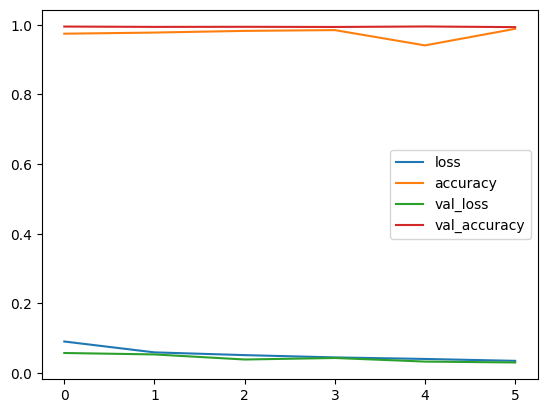

In [39]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [42]:
with tf.device('/CPU:0'):
    loss, acc = multilingual_ds.evaluate(test, verbose = 0)

In [43]:
print('Test accuracy %f' % (acc * 100))

Test accuracy 99.361652


In [45]:
from tensorflow.keras.metrics import Precision, Recall

pre = Precision()
re = Recall()


with tf.device('/CPU:0'):
    for batch in test.as_numpy_iterator():
        #Unpack the batch
        X_true, y_true = batch
        #Make prediction
        yhat = multilingual_ds.predict(X_true)

        y_true = y_true.flatten()
        yhat = yhat.flatten()

        pre.update_state(y_true, yhat)
        re.update_state(y_true, yhat)
     

1/1 [==============================] - 0s 43ms/step


2023-03-03 15:37:05.076754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 41ms/step


In [46]:
f1_score = 2*(pre.result().numpy() * re.result().numpy())/(pre.result().numpy() + re.result().numpy())
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, F1-score:{f1_score}')

Precision: 0.9151177406311035, Recall:0.7531871795654297, F1-score:0.8262937203049485


In [47]:
from sklearn.metrics import accuracy_score
ci_length = z_value * np.sqrt((acc * (1 - acc)) / y.shape[0])
ci_lower = acc - ci_length
ci_upper = acc + ci_length
print("Lower bound: ", ci_lower, "Upper bound: ", ci_upper)
print()
print("So, the above values represent the 95% confidence interval around the test set accuracy")

Lower bound:  0.9928645732481107 Upper bound:  0.9943684694688693

So, the above values represent the 95% confidence interval around the test set accuracy


In [28]:
batch_X, batch_y =  test.as_numpy_iterator().next()

In [42]:
input_text = vectorizer('Я тебя люблю, идиот, но ты не доверяешь мне')

In [43]:
(multilingual_ds.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 85ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [44]:
multilingual_ds.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 51ms/step


array([[0.9799595 , 0.26544863, 0.8494947 , 0.05987415, 0.7314346 ,
        0.25315458]], dtype=float32)

Based on the given values, we can interpret the model's performance as follows:

The model has an accuracy of 0.99, which is very high, indicating that the model correctly classifies 99% of the samples.

The model has a precision of 0.91, which means that out of all positive predictions made by the model, 91% were true positives.

The model has a recall of 0.75, which means that out of all actual positive samples, the model correctly identified 75% of them.

The model has an F1-score of 0.82, which is a harmonic mean of precision and recall, providing a balanced measure of both metrics.

In [2]:
import gradio as gr

In [116]:
multilingual_ds.save('mult_toxicity.h5')

In [21]:
multilingual_ds.load_weights('mult_toxicity.h5')

In [24]:
multilingual_dataset.columns[3:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
#multilingual_ds = tf.keras.models.load_model('toxicity.h5')

In [25]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = multilingual_ds.predict(vectorized_comment)
    
    text =''
    for idx, col in enumerate(multilingual_dataset.columns[3:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    return text

In [26]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'), outputs='text')

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [38]:
#interface.launch()
interface.close()

Closing server running on port: 7860


## Multilingual CNN

In [144]:
#MCSHBAP - map, cache, shuffle, batch, prefetch
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(40_000)
dataset = dataset.batch(20)
dataset = dataset.prefetch(10) #help prevents bottlenecks

In [145]:
len(dataset)

2155

In [147]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.1))
test = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*.2))

In [153]:
from keras.layers import Dense, Embedding, Flatten, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.metrics import Precision, Recall

max_features = MAX_FEATURES
max_comment_length = 1800
embedding_dim = 64


mult_model = Sequential()
mult_model.add(Embedding(input_dim=max_features, 
                    output_dim=embedding_dim, 
                    input_length=max_comment_length))
mult_model.add(Conv1D(filters=embedding_dim*5, 
                 kernel_size=4, 
                 activation='relu'))
mult_model.add(GlobalMaxPooling1D())
mult_model.add(Dense(6, activation='sigmoid'))


mult_model.summary()

mult_model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 1800, 64)          2560000   
                                                                 
 conv1d_5 (Conv1D)           (None, 1797, 320)         82240     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 320)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_13 (Dense)            (None, 6)                 1926      
                                                                 
Total params: 2,644,166
Trainable params: 2,644,166
Non-trainable params: 0
_________________________________________________________________


In [157]:
import time
from keras.callbacks import ReduceLROnPlateau

epochs = 4

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

with tf.device('/CPU:0'):
    mult_model.fit(train, epochs = epochs, validation_data=val, batch_size= 512, callbacks=[reduce_lr])

Epoch 1/4


2023-03-04 16:12:12.441829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1508/1508 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9582

2023-03-04 16:19:36.637972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1508/1508 [==============================] - 450s 299ms/step - loss: 0.0875 - accuracy: 0.9582 - val_loss: 0.0576 - val_accuracy: 0.6774 - lr: 0.0010
Epoch 2/4
1508/1508 [==============================] - 447s 297ms/step - loss: 0.0572 - accuracy: 0.8826 - val_loss: 0.0437 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 3/4
1508/1508 [==============================] - 457s 303ms/step - loss: 0.0450 - accuracy: 0.7717 - val_loss: 0.0334 - val_accuracy: 0.3114 - lr: 0.0010
Epoch 4/4
1508/1508 [==============================] - 437s 290ms/step - loss: 0.0330 - accuracy: 0.6459 - val_loss: 0.0241 - val_accuracy: 0.5221 - lr: 0.0010


In [159]:
with tf.device('/CPU:0'):
    loss, acc = multilingual_ds.evaluate(test, verbose = 0)

In [160]:
print('Test accuracy %f' % (acc * 100))

Test accuracy 99.547142


In [165]:
print('Test accuracy %f' % (loss))

Test accuracy 0.029040


In [162]:
from tensorflow.keras.metrics import Precision, Recall

pre = Precision()
re = Recall()


with tf.device('/CPU:0'):
    for batch in test.as_numpy_iterator():
        #Unpack the batch
        X_true, y_true = batch
        #Make prediction
        yhat = multilingual_ds.predict(X_true)

        y_true = y_true.flatten()
        yhat = yhat.flatten()

        pre.update_state(y_true, yhat)
        re.update_state(y_true, yhat)

1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 48ms/step


In [163]:
f1_score = 2*(pre.result().numpy() * re.result().numpy())/(pre.result().numpy() + re.result().numpy())
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, F1-score:{f1_score}')

Precision: 0.907903790473938, Recall:0.7583237290382385, F1-score:0.8263996771915666


In [164]:
from sklearn.metrics import accuracy_score
ci_length = z_value * np.sqrt((acc * (1 - acc)) / y.shape[0])
ci_lower = acc - ci_length
ci_upper = acc + ci_length
print("Lower bound: ", ci_lower, "Upper bound: ", ci_upper)
print()
print("So, the above values represent the 95% confidence interval around the test set accuracy")

Lower bound:  0.994837482093157 Upper bound:  0.9961053537146433

So, the above values represent the 95% confidence interval around the test set accuracy


## Logical Regression

Logistic Regression in scikit-learn expects a 1D array for the target variable, where each value represents the class label for the corresponding sample. If you have a multi-class classification problem with 6 classes, you can use the MultiOutputClassifier wrapper to fit multiple logistic regression models, one for each class.

Here's an example of how you can use MultiOutputClassifier to fit multiple logistic regression models for multi-class classification:

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Assume X and y are your feature set and target variable, respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report

# create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# transform the testing data
X_test_tfidf = vectorizer.transform(X_test)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Create a logistic regression object
lr = LogisticRegression()

# Create a multi-output logistic regression object
multi_lr = MultiOutputClassifier(lr)

# Fit the multi-output logistic regression model to the training data
multi_lr.fit(X_train_tfidf, y_train)

# Predict the class labels for the test data
y_pred = multi_lr.predict(X_test_tfidf)

In [39]:
accuracy_test = multi_lr.score(X_test_tfidf, y_test)
print("Mean accuracy of logical regression model: ", accuracy_test )

Mean accuracy of logical regression model:  0.9062609303952431


In [40]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.37      0.54       836
           1       0.43      0.03      0.06        89
           2       0.94      0.36      0.52       462
           3       0.00      0.00      0.00        30
           4       0.86      0.28      0.42       430
           5       0.50      0.01      0.02        82

   micro avg       0.93      0.31      0.47      1929
   macro avg       0.62      0.18      0.26      1929
weighted avg       0.88      0.31      0.45      1929
 samples avg       0.03      0.03      0.03      1929



/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

In [196]:
from sklearn.metrics import accuracy_score

ci_length = z_value * np.sqrt((accuracy_test * (1 - accuracy_test)) / y_test.shape[0])

ci_lower = accuracy_test - ci_length
ci_upper = accuracy_test + ci_length

print("Lower bound: ", ci_lower, "Upper bound: ", ci_upper)
print()
print("So, the above values represent the 95% confidence interval around the test set accuracy")

Lower bound:  0.8975925866346011 Upper bound:  0.910041709687478

So, the above values represent the 95% confidence interval around the test set accuracy


Accuracy is just one metric for evaluating the performance of a classification model, and it is not always the most appropriate metric, especially when dealing with imbalanced datasets or multiclass classification problems.

In your case, the accuracy is 0.91, which means that 91% of the predictions made by the model were correct. However, looking at the precision, recall, and F1-score for each class, we can see that the model is performing poorly on some classes (e.g., class 1, 3, and 5), and better on others (e.g., class 0, 2, and 4). This means that the overall accuracy may be high, but the model is struggling to correctly identify some of the classes, which may be important for your specific application.

Therefore, it is important to consider all the evaluation metrics, including precision, recall, and F1-score, to assess the performance of the model on each class and determine if it meets your requirements.

In this example, X_train is the training data with shape (n_samples, n_features), and y_train is the target variable with shape (n_samples, n_classes), where n_classes is 6 in your case. MultiOutputClassifier will fit multiple logistic regression models, one for each column in y_train, and return an array of predicted class labels with shape (n_samples, n_classes)

## Multinomial Naive Bayes 

In [42]:
y.shape

(42881, 6)

In [44]:
print(y_train)

[0 0 0 ... 0 0 0]


In [45]:
from sklearn.datasets import load_digits
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# transform the testing data
X_test_tfidf = vectorizer.transform(X_test)

# Create a Multinomial Naive Bayes model
nb = MultinomialNB()
# Create a multi-output logistic regression object
multi_mbc = MultiOutputClassifier(nb)

# Train the model on the training data
multi_mbc.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
y_pred = multi_mbc.predict(X_test_tfidf)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))


Accuracy: 0.8980956082394093


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.11      0.20      1253
           1       0.00      0.00      0.00       129
           2       0.97      0.05      0.10       686
           3       0.00      0.00      0.00        47
           4       0.83      0.01      0.02       630
           5       0.00      0.00      0.00       113

   micro avg       0.99      0.06      0.12      2858
   macro avg       0.47      0.03      0.05      2858
weighted avg       0.86      0.06      0.12      2858
 samples avg       0.01      0.00      0.01      2858



/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

In [210]:
multilingual_dataset.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,426417035bd5b20c,пропонований злиття неформалізм стаття існуват...,0.0,0.0,0.0,0.0,0.0,0.0
1,1,4264fd1c363935d3,колір фон заповнення колір фон світлосірий вер...,0.0,0.0,0.0,0.0,0.0,0.0
2,2,4265fd7c2447bc08,жила скеля половина австралійський англійський...,0.0,0.0,0.0,0.0,0.0,0.0
3,3,4266b67c57e3cfbb,японський назва місто переглянути пост вікіпед...,0.0,0.0,0.0,0.0,0.0,0.0
4,4,426a0fd1b3460373,небажання обговорювати будьякий змінити свідчи...,1.0,0.0,0.0,0.0,0.0,0.0


In [221]:
multilingual_dataset[multilingual_dataset['toxic'] == 1].count()

Unnamed: 0       4175
id               4175
comment_text     4133
toxic            4175
severe_toxic     4175
obscene          4175
threat           4175
insult           4175
identity_hate    4175
dtype: int64

In [212]:
multilingual_dataset[multilingual_dataset['severe_toxic'] == 1].count()

Unnamed: 0       436
id               436
comment_text     423
toxic            436
severe_toxic     436
obscene          436
threat           436
insult           436
identity_hate    436
dtype: int64

In [213]:
multilingual_dataset[multilingual_dataset['obscene'] == 1].count()

Unnamed: 0       2256
id               2256
comment_text     2228
toxic            2256
severe_toxic     2256
obscene          2256
threat           2256
insult           2256
identity_hate    2256
dtype: int64

In [219]:
multilingual_dataset[multilingual_dataset['threat'] == 1].count()

Unnamed: 0       143
id               143
comment_text     141
toxic            143
severe_toxic     143
obscene          143
threat           143
insult           143
identity_hate    143
dtype: int64

In [217]:
multilingual_dataset[multilingual_dataset['insult'] == 1].count()

Unnamed: 0       2076
id               2076
comment_text     2055
toxic            2076
severe_toxic     2076
obscene          2076
threat           2076
insult           2076
identity_hate    2076
dtype: int64

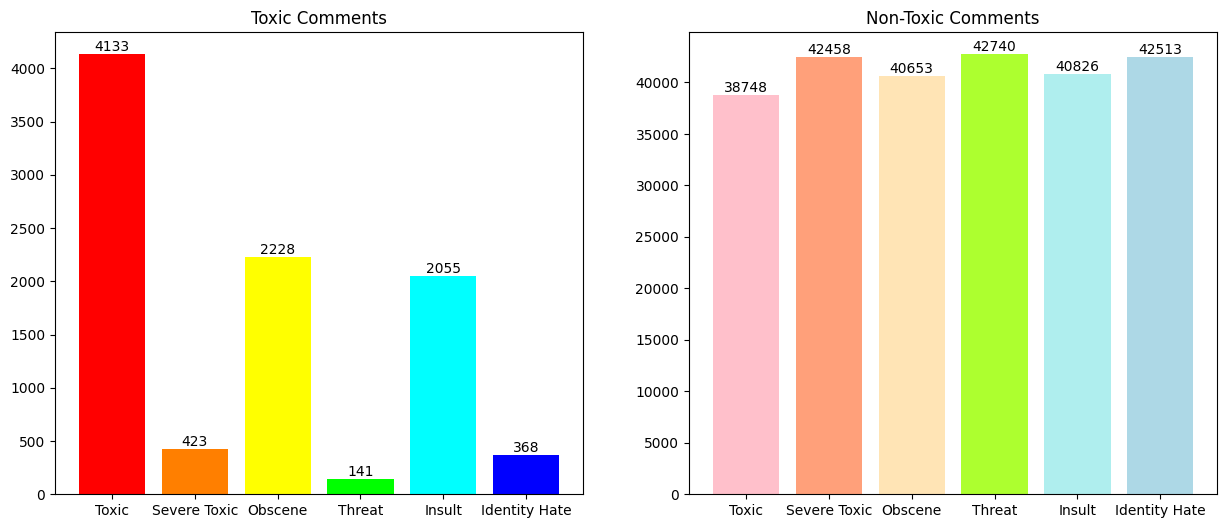

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Get the counts for each label
labels = ['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']
toxic_counts = [multilingual_ds[multilingual_ds['toxic'] == 1].count()[0], multilingual_ds[multilingual_ds['severe_toxic'] == 1].count()[0],
                multilingual_ds[multilingual_ds['obscene'] == 1].count()[0], multilingual_ds[multilingual_ds['threat'] == 1].count()[0],
                multilingual_ds[multilingual_ds['insult'] == 1].count()[0], multilingual_ds[multilingual_ds['identity_hate'] == 1].count()[0]]
non_toxic_counts = [multilingual_ds[multilingual_ds['toxic'] == 0].count()[0], multilingual_ds[multilingual_ds['severe_toxic'] == 0].count()[0],
                    multilingual_ds[multilingual_ds['obscene'] == 0].count()[0], multilingual_ds[multilingual_ds['threat'] == 0].count()[0],
                    multilingual_ds[multilingual_ds['insult'] == 0].count()[0], multilingual_ds[multilingual_ds['identity_hate'] == 0].count()[0]]

# Set the colors for the bars
toxic_colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#00FFFF', '#0000FF']
non_toxic_colors = ['#FFC0CB', '#FFA07A', '#FFE4B5', '#ADFF2F', '#AFEEEE', '#ADD8E6']

# Create two separate plots, one for the toxic comments and one for the non-toxic comments
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the bars for the toxic comments
ax1.bar(labels, toxic_counts, color=toxic_colors)
ax1.set_title('Toxic Comments')
for i, count in enumerate(toxic_counts):
    ax1.annotate(str(count), (labels[i], count), ha='center', va='bottom')

# Plot the bars for the non-toxic comments
ax2.bar(labels, non_toxic_counts, color=non_toxic_colors)
ax2.set_title('Non-Toxic Comments')
for i, count in enumerate(non_toxic_counts):
    ax2.annotate(str(count), (labels[i], count), ha='center', va='bottom')

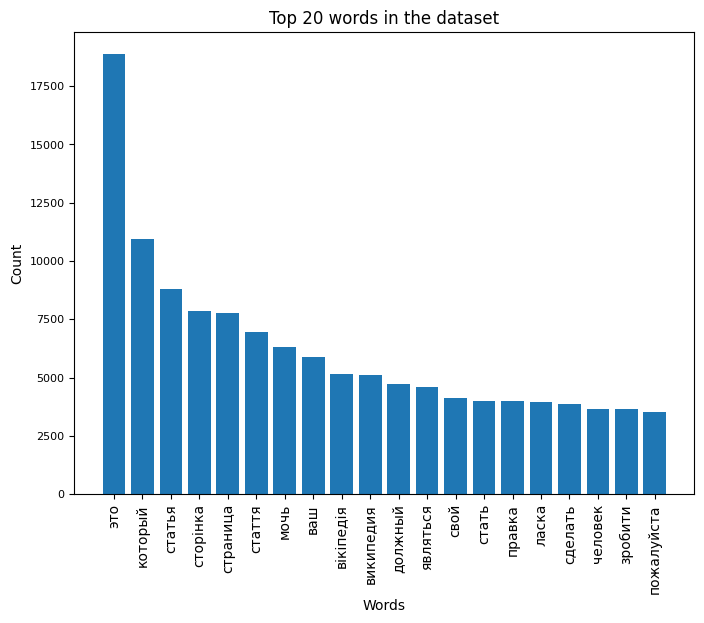

In [78]:
import matplotlib.pyplot as plt
from collections import Counter

# Tokenize the text
tokens = multilingual_ds['comment_text'].str.lower().str.split()

# Count the tokens
word_counts = Counter([word for sentence in tokens for word in sentence])

# Select the most frequent tokens
num_top_words = 20
top_words = dict(word_counts.most_common(num_top_words))

# Plot the distribution of most frequent tokens
plt.figure(figsize=(8,6))
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=8)
plt.title('Top {} words in the dataset'.format(num_top_words), fontsize=12)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.show()

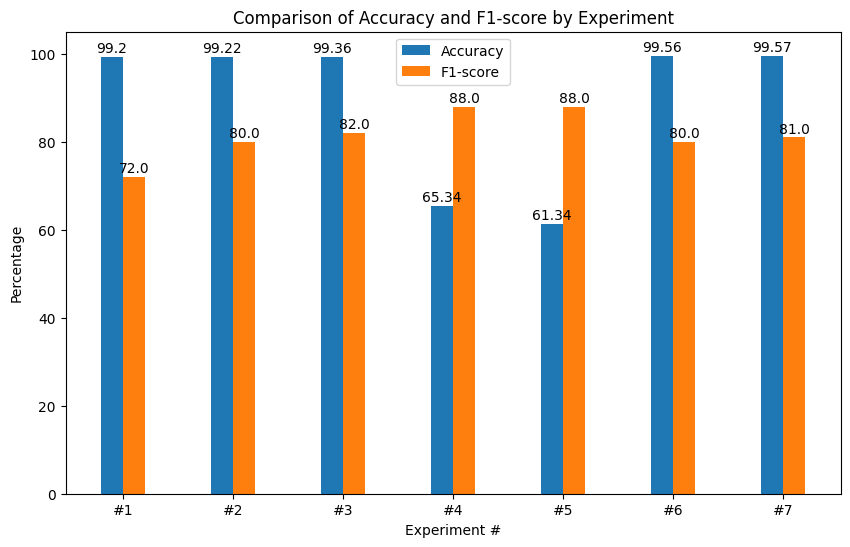

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# define the data
experiments = ["#1", "#2", "#3", "#4", "#5", "#6", "#7"]
algorithm = ["Mult-BiLSTM", "Mult-BiLSTM", "Mult-BiLSTM", "Mult-BiLSTM", "Mult-BiLSTM", "BiLSTM (Ukrainian)", "BiLSTM (Russian)"]
accuracy = [99.20, 99.22, 99.36, 65.34, 61.34, 99.56, 99.57]
recall = [0.61, 0.73, 0.75, 0.82261, 0.86741, 0.71, 0.74]
precision = [0.88, 0.87, 0.91, 0.95675, 0.89827, 0.92, 0.90]
f1_score = [72.0, 80.0, 82.0, 88.0, 88.0, 80.0, 81.0]

# set the figure size
fig, ax = plt.subplots(figsize=(10, 6))

# set the bar width
bar_width = 0.2

# set the x positions
x_pos = np.arange(len(experiments))

# plot the bars
ax.bar(x_pos - bar_width, accuracy, width=bar_width, label="Accuracy")
ax.bar(x_pos, f1_score, width=bar_width, label="F1-score")

# set the x-axis labels and tick positions
ax.set_xticks(x_pos - bar_width/2)
ax.set_xticklabels(experiments)
ax.set_xlabel("Experiment #")

# set the y-axis label and limit
ax.set_ylabel("Percentage")
ax.set_ylim([0, 105])

# set the legend
ax.legend()

# add the data labels to the bars
for i, v in enumerate(accuracy):
    ax.text(i - bar_width, v + 1, str(v), ha="center")
    ax.text(i, f1_score[i] + 1, str(f1_score[i]), ha="center")

# set the plot title
plt.title("Comparison of Accuracy and F1-score by Experiment")

# show the plot
plt.show()


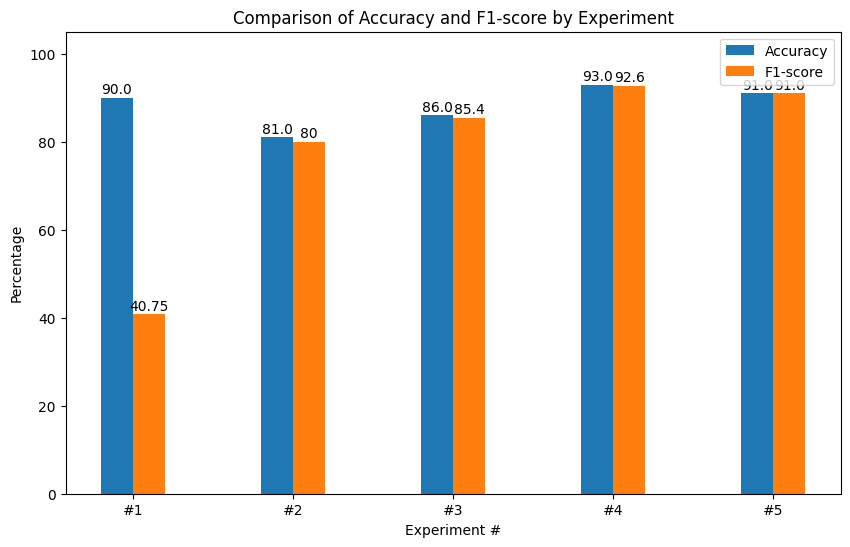

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# define the data
experiments = ["#1", "#2", "#3", "#4", "#5"]
#algorithm = ["Bert-basee"]
accuracy = [90.0, 81.0, 86.0, 93.0, 91.0]
# recall = [99.20, 0.73, 0.75, 0.82261, 0.86741, 0.71, 0.74]
# precision = [0.88, 0.87, 0.91, 0.95675, 0.89827, 0.92, 0.90]
f1_score = [40.75, 80, 85.4, 92.6, 91.0]

# set the figure size
fig, ax = plt.subplots(figsize=(10, 6))

# set the bar width
bar_width = 0.2

# set the x positions
x_pos = np.arange(len(experiments))

# plot the bars
ax.bar(x_pos - bar_width, accuracy, width=bar_width, label="Accuracy")
ax.bar(x_pos, f1_score, width=bar_width, label="F1-score")

# set the x-axis labels and tick positions
ax.set_xticks(x_pos - bar_width/2)
ax.set_xticklabels(experiments)
ax.set_xlabel("Experiment #")

# set the y-axis label and limit
ax.set_ylabel("Percentage")
ax.set_ylim([0, 105])

# set the legend
ax.legend()

# add the data labels to the bars
for i, v in enumerate(accuracy):
    ax.text(i - bar_width, v + 1, str(v), ha="center")
    ax.text(i, f1_score[i] + 1, str(f1_score[i]), ha="center")

# set the plot title
plt.title("Comparison of Accuracy and F1-score by Experiment")

# show the plot
plt.show()
